[home](http://www.brandonrose.org)

# Document Clustering with Python

<img src='header_short.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

In [11]:
import numpy as np
import pandas as pd
import nltk
# from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import json

In [13]:
json_data=open('condensed_2016.json').read()

all_dat_16 = pd.read_json(json_data)
all_dat_16.head()


json_data=open('condensed_2017.json').read()

all_dat_17 = pd.read_json(json_data)
all_dat_17.head()

created_at  favorite_count              id_str  \
0 2017-12-01 21:49:27           27875  936713881711529984   
1 2017-12-01 20:08:22           55759  936688444046266368   
2 2017-12-01 17:23:17               0  936646898408218624   
3 2017-12-01 11:21:06           67942  936555753946705920   
4 2017-12-01 11:13:35           96371  936553863255031808   

   in_reply_to_user_id_str  is_retweet  retweet_count              source  \
0                      NaN       False           7587  Twitter for iPhone   
1                      NaN       False          14807  Twitter for iPhone   
2                      NaN        True           4535  Twitter for iPhone   
3                      NaN       False          15381  Twitter for iPhone   
4                      NaN       False          25379  Twitter for iPhone   

                                                text  
0  Economists on the TAX CUTS and JOBS ACT:\n\n“T...  
1  The media has been speculating that I fired Re...  
2  RT @WhiteHouse: President Trump proclaims toda...  
3  Republicans Senators are working hard to pass ...  
4  The jury was not told the killer of Kate was a...

In [14]:
frames = [all_dat_17, all_dat_16]
all_dat = pd.concat(frames)
all_dat = all_dat.reset_index(drop=True)

In [15]:
len(all_dat)

6637

In [16]:
synopses = all_dat['text'].tolist()

In [17]:
rank = [x for x in range(0, 4225)]

# Stopwords, stemming, and tokenizing

In [3]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [4]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [5]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [11]:
type(synopses)

list

In [12]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [18]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [19]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [20]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [21]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [22]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 124804 items in vocab_frame


## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=10, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 6.12 s, sys: 92 ms, total: 6.22 s
Wall time: 6.21 s
(6637, 1482)


In [24]:
terms = tfidf_vectorizer.get_feature_names()

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [27]:
from sklearn.cluster import KMeans

num_clusters = 15

km = KMeans(n_jobs=-1, n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 172 ms, sys: 380 ms, total: 552 ms
Wall time: 2.34 s


In [28]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [29]:
import pandas as pd

# films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

tweets = {'synopsis': synopses,  'cluster': clusters}

frame = pd.DataFrame(tweets, index = [clusters] , columns = ['synopsis', 'cluster'])

In [31]:
frame['cluster'].value_counts()

0     2443
6      453
1      440
12     422
5      383
9      373
2      340
8      335
4      332
3      289
7      226
14     177
11     146
13     146
10     132
Name: cluster, dtype: int64

In [61]:
frame.to_csv('tweets.csv', encoding='utf-8')

In [140]:
# grouped = frame['rank'].groupby(frame['cluster'])

# grouped.mean()

In [65]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    #print("Cluster %d titles:" % i, end='')
    #for title in frame.ix[i]['title'].values.tolist():
    #    print(' %s,' % title, end='')
    print()


Top terms per cluster:

Cluster 0 words: https, great, very, jobs, just, today, big, 's, country, looking, states, president, time, years, many, new, national, failing, day, totally,

Cluster 1 words: thank, https, makeamericagreatagain, makeamericagreatagain, trump2016, great, thank, support, americafirst, votetrump, new, americafirst, maga, imwithyou, thank, florida, soon, polls, trump2016, carolina,

Cluster 2 words: hillary, crooked, crooked, hillary, clinton, crooked, bad, bernie, n't, 's, https, want, just, judgement, rigged, sanders, bad, bernie, said, hillary,

Cluster 3 words: realdonaldtrump, trump, https, 's, thank, vote, megynkelly, great, makeamericagreatagain, realdonaldtrump, love, president, megynkelly, cnn, n't, realdonaldtrump, like, vote, foxnews, realdonaldtrump,

Cluster 4 words: trump, donald, https, donald, 's, president, polls, vote, j., donald, donald, just, j., winning, trump, tower, gop, rubio, trump, cruz,

Cluster 5 words: https, join, tickets, tickets, tom

In [128]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
# frame['Rank'] = frame['rank'] + 1
# frame['Title'] = frame['title']

In [129]:
#export tables to HTML
# print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

# Multidimensional scaling

In [34]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_jobs=-1, n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

CPU times: user 3.66 s, sys: 1.07 s, total: 4.73 s
Wall time: 7min 55s


In [35]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [37]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                 5: '#1b5e77', 6: '#d90f02', 7: '#7070b3', 8: '#e7098a', 9: '#66361e',
                 10: '#1bce77', 11: '#d99f02',12: '#7970b3', 13: '#e7698a', 14: '#66d61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

cluster_names = {0: '0', 
                 1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4',
                5: '5', 
                 6: '6', 
                 7: '7', 
                 8: '8', 
                 9: '9',
                10: '10', 
                11: '11', 
                 12: '12', 
                 13: '13', 
                 14: '14'}

In [38]:
%matplotlib inline

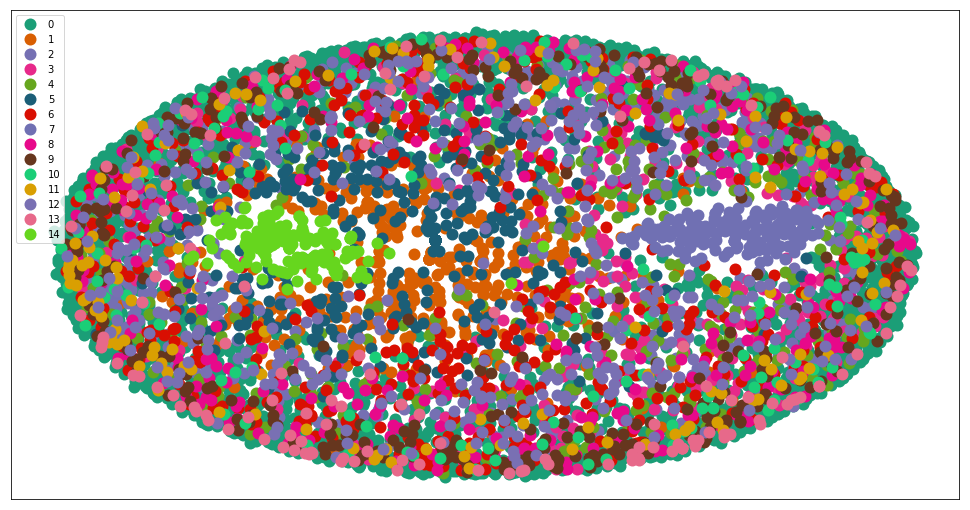

In [39]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, synopsis=synopses)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['synopsis'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [156]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [40]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [41]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=synopses)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(10,6)) #set plot size

ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

In [167]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=synopses);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

ValueError: 
When I look at all of the money the special interests and lobbyists are giving to candidates, beware - the candidates are mere puppets $$$$!
                                                                                                                                       ^
Expected end of text (at char 135), (line:1, col:136)

ValueError: 
When I look at all of the money the special interests and lobbyists are giving to candidates, beware - the candidates are mere puppets $$$$!
                                                                                                                                       ^
Expected end of text (at char 135), (line:1, col:136)

In [60]:
plt.close()

# Latent Dirichlet Allocation

In [42]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [43]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [46]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 2.63 s, sys: 8 ms, total: 2.64 s
Wall time: 2.64 s
CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 243 ms


In [47]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

10


In [48]:
dictionary = corpora.Dictionary(texts)

In [49]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [50]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [51]:
len(corpus)

6637

In [54]:
%time lda = models.LdaMulticore(corpus, num_topics=15, workers=40, id2word=dictionary, chunksize=10000, passes=100)

CPU times: user 20min 17s, sys: 1min 11s, total: 21min 28s
Wall time: 21min


In [55]:
print(lda[corpus[0]])

[(0, 0.3714125760527397), (4, 0.42882861503433695), (9, 0.12703148418943203)]


In [56]:
topics = lda.print_topics(15, num_words=20)

In [57]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [58]:
for i in range(0,len(topics_matrix)):
    print("topic "+str(i)+": ")
    for k in range(0,20):
        print(topics_matrix[i][1][k])
    print('\n')

topic 0: 
(u'ever', 0.024745712249716216)
(u'run', 0.022510583943733137)
(u'one', 0.018846256243350297)
(u'debat', 0.017392279104574606)
(u'presid', 0.016231836434565879)
(u'far', 0.014719383910871166)
(u'would', 0.014660540352639665)
(u'right', 0.013876438308320478)
(u'histori', 0.013747332368690151)
(u'onli', 0.013109208789797483)
(u"'s", 0.012242446476121101)
(u'candid', 0.010814249538546929)
(u'last', 0.010310683046749687)
(u'beat', 0.010064291613951988)
(u'news', 0.0096097050548793299)
(u'best', 0.0092003510685264526)
(u'thing', 0.00908252623536486)
(u'campaign', 0.0084025765073732651)
(u'media', 0.0082300229722147272)
(u'never', 0.008054451914891566)


topic 1: 
(u'offic', 0.017601264106121423)
(u'law', 0.015990537664573017)
(u'campaign', 0.015111533086257005)
(u'spent', 0.013224958803982747)
(u'enforc', 0.012425262505373035)
(u'email', 0.011790019977621358)
(u'sinc', 0.01155117424789345)
(u'poll', 0.010854332087112452)
(u'press', 0.010801540196991153)
(u'control', 0.010733908356

In [208]:
texts

[['https'],
 ['https'],
 ['includ', 'mani', 'enemi', 'fought', 'lost', 'bad', "n't", 'know'],
 ['play', 'fool', 'funni', 'watch', "n't", 'clue', 'total', 'get'],
 ['found', 'legend', 'https'],
 ['move', 'delay', 'alway', 'knew', 'veri', 'smart'],
 ['follow', 'two', 'simpl', 'rule', 'https'],
 ['say', 'deliv', 'hope', 'https'],
 ['anymor',
  'begin',
  'end',
  'horribl',
  'deal',
  'strong',
  '20th',
  'fast',
  'approach'],
 ['continu',
  'let',
  'treat',
  'total',
  'disdain',
  'disrespect',
  'use',
  'great',
  'friend'],
 ['best',
  'disregard',
  'mani',
  'inflammatori',
  'statement',
  'go',
  'smooth',
  'transit'],
 ['surg', 'near', 'four', 'point'],
 ['campaign',
  'hard',
  'person',
  'veri',
  'import',
  'swing',
  'state',
  'voter',
  'want'],
 ['unlik',
  'foundat',
  'never',
  'paid',
  'fee',
  'rent',
  'salari',
  'ani',
  'expens',
  'money',
  'goe',
  'wonder',
  'chariti'],
 ['gave',
  'million',
  'dollar',
  'rais',
  'reciev',
  'million',
  'given',